# Elastodynamics - Implicit integrator

Strong form
\begin{equation}
    \rho\ddot{\mathbf{u}} = \mathbf{b} + \mathrm{div}{\boldsymbol\sigma}.
\end{equation}

Weak formulation of elastodynamic medium in specific time instant $t_{i+1}$ reads: Find $\mathbf{u}_{i+1}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}_{i+1}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + 
\int_\Omega\rho\ddot{\mathbf{u}}_{i+1}\cdot\delta\mathbf{u}\,\mathrm{d}\Omega +
\int_{\partial\Omega}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u},
\end{equation}
where again
\begin{equation}
\boldsymbol{\sigma}=\lambda\mathrm{tr}(\boldsymbol{\varepsilon})\mathbf{I} + 2\mu\boldsymbol{\varepsilon}, \boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\mathbf{u}+\nabla^{\mathrm{T}}\mathbf{u}\right), \delta\boldsymbol{\varepsilon}=\frac{1}{2}\left(\nabla\delta\mathbf{u}+\nabla^{\mathrm{T}}\delta\mathbf{u}\right).
\end{equation}

Time integration scheme depends on discretization of second derivative. For constant acceleration Newmark method speed and displacement in time $t_{i+1}$ can be evaluated based on values in time $t_i$ as
\begin{equation}
\dot{\mathbf{u}}_{i+1}=\dot{\mathbf{u}}_{i} + \frac{\Delta t}{2}(\ddot{\mathbf{u}}_{i} + \ddot{\mathbf{u}}_{i+1}),
\end{equation}
\begin{equation}
\mathbf{u}_{i+1} = \mathbf{u}_{i} + \Delta t\dot{\mathbf{u}}_{i} + \frac{\Delta t^2}{4}(\ddot{\mathbf{u}}_{i} + \ddot{\mathbf{u}}_{i+1}),
\end{equation}
which can be rearranged to
\begin{equation}
\ddot{\mathbf{u}}_{i+1} = \frac{4}{\Delta t^2}(\mathbf{u}_{i+1} - \tilde{\mathbf{u}}_{i}),
\end{equation}
where auxiliary variable
\begin{equation}
\tilde{\mathbf{u}}_{i} = \mathbf{u}_{i} + \Delta t\dot{\mathbf{u}}_{i} + \frac{\Delta t^2}{4}\ddot{\mathbf{u}}_{i}
\end{equation}
depends only on old values. After substituting to previous weak form, we get final relationship for $\mathbf{u}_{i+1}$ calculation:

Find $\mathbf{u}_{i+1}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}_{i+1}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + 
\int_\Omega\rho\left(\frac{4}{\Delta t^2}(\mathbf{u}_{i+1} - \tilde{\mathbf{u}}_{i})\right)\cdot\delta\mathbf{u}\,\mathrm{d}\Omega +
\int_{\partial\Omega}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u},
\end{equation}

## Implementation

We again import all neccessary packages and define auxiliary functions and parameters. 

In [103]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import time


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


def indent_area(x, on_boundary):
    return (on_boundary and fe.near(x[1], l_y) and abs(x[0] - 0.5*l_x) < 0.2*l_x)


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.1

# Lame's constants
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
rho = 200.0

l_x, l_y = 5.0, 5.0  # Domain dimensions

And we also define start time, end time and time step. There is many options how define time loop, it is possible for example via `linspace()` which create equidistantly distributed array of numbers. 

In [104]:
# Time-stepping
t_start = 0.0  # start time
t_end = 1.0e-1  # end time
t_steps = 100  # number of time steps

t = np.linspace(t_start, t_end, t_steps)
dt = np.asscalar(t[1] - t[0])

Mesh is created using predefined object `BoxMesh`.

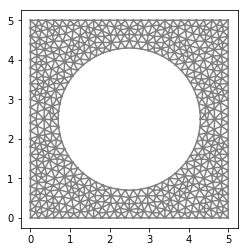

In [105]:
# --------------------
# Geometry
# --------------------
mesh = fe.Mesh("external_mesh.xml")

fe.plot(mesh)
plt.show()

As earlier we create vector-value function space and appropriate trial and test function.

In [106]:
# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

Neumann boundary conditions are prescribed as previously. For moving Dirichlet boundary condition we can also in each time step define new `DirichletBC` object and send it to solver. There is more elegant way using FEniCS object `Expression`. It represents user-defined function of selected degree. Function is defined by C/C++ syntax and it can contain any number of free parameters. In our case we parametrized function by pseudo time $t$ which is constant in space (degree=0). It is allowed change of expression by command `u_D.t=...`.

In [107]:
# --------------------
# Boundary conditions
# --------------------
u_D = fe.Expression(" t < 1.0e-2 ? -100*t : -1.0", t=0.0, degree=0)

bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(V.sub(1), u_D, indent_area)
bc = [bc1, bc2]

Now we can create all functions we need, where `u_bar` represents $\tilde{\mathbf{u}}$, `du` is $\dot{\mathbf{u}}$ and `ddu` is $\ddot{\mathbf{u}}$.

In [108]:
# --------------------
# Initialization
# --------------------
u = fe.Function(V)
u_bar = fe.Function(V)
du = fe.Function(V)
ddu = fe.Function(V)
ddu_old = fe.Function(V)

We need also identify output file. In dynamic regime it is valuabe works with `.xdmf` files. Creation is perfomed by

In [109]:
file = fe.XDMFFile("FEniCS_implicit_output.xdmf")  # XDMF file

Finally, we can write down the weak form of our problem. We define this form outside of time loop. It is possible by using object `Function`. For example if we use `u_tr` in formulation, FEniCS remember the pointer on this object. We cannot redefine `u_tr` by classic way `u_tr=...`, but we must use methods of `Function` for redefining, shown later.

In [110]:
# --------------------
# Weak form
# --------------------
A_form = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx + 4*rho/(dt*dt)*fe.dot(u_tr - u_bar, u_test)*fe.dx

Time loop is simple `for` cycle where the first line is redefinition of `u_bar` for given time step. Next part is classical solver and the rest is updating of auxiliary variables `ddu_old`, `ddu` and `du`. Line `file.write(u, ti)` write displacement solution to output file, where second argument is given time. There is used `Function` object method `.assign` for updating. This method assign linear combination of functions or sub-functions of to single receiving function. The linear combination and receiving function must be element of the same function space.

In [111]:
# --------------------
# Time loop
# --------------------
for ti in t:
    u_D.t = ti
    u_bar.assign(u + dt*du + 0.25*dt*dt*ddu)
    
    #A, b = fe.assemble_system(fe.lhs(A_form), fe.rhs(A_form), bc)
    #fe.solve(A, u.vector(), b, "cg", "jacobi")
    fe.solve(fe.lhs(A_form) == fe.rhs(A_form), u, bc)
    
    ddu_old.assign(ddu)
    ddu.assign(4/(dt*dt)*(u - u_bar))
    du.assign(du + 0.5*dt*(ddu + ddu_old))

    file.write(u, ti)
    
    #print(ti)
file.close()

### Explicit integrator

In Forward-Euler method, acceleration in time $t_{i}$ is approximated by forward finite difference as
\begin{equation}
\ddot{\mathbf{u}}_{i+1}=\frac{\mathbf{u}_{i+2} - 2\mathbf{u}_{i+1} + \mathbf{u}_{i}}{\Delta t^2}.
\end{equation}

After substituting to previous weak form, we get final relationship for $\mathbf{u}_{i+2}$ calculation:

Find $\mathbf{u}_{i+2}$ s.t.
\begin{equation}
\int_\Omega\boldsymbol{\sigma}_{i}:\delta\boldsymbol{\varepsilon}\ \mathrm{d}\Omega + \int_\Omega \mathbf{b}\cdot\delta\mathbf{u}\ \mathrm{d}\Omega + 
\int_\Omega\rho\frac{\mathbf{u}_{i+2} - 2\mathbf{u}_{i+1} + \mathbf{u}_{i}}{\Delta t^2}\cdot\delta\mathbf{u}\,\mathrm{d}\Omega +
\int_{\partial\Omega}\mathbf{f}\cdot\delta\mathbf{u}\ \mathrm{d}\partial\Omega = 0, \forall \delta\mathbf{u},
\end{equation}

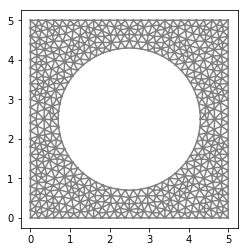

In [112]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np
import time


# --------------------
# Functions and classes
# --------------------
def bottom(x, on_boundary):
    return (on_boundary and fe.near(x[1], 0.0))


def indent_area(x, on_boundary):
    return (on_boundary and fe.near(x[1], l_y) and abs(x[0] - 0.5*l_x) < 0.2*l_x)


# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)


# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(2) + 2*mu*epsilon(u)


# --------------------
# Parameters
# --------------------
# Young's modulus and Poisson's ratio
E = 0.02e9
nu = 0.1

# Lame's constants
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)
rho = 200.0

l_x, l_y = 5.0, 5.0  # Domain dimensions

# Time-stepping
t_start = 0.0  # start time
t_end = 1.0e-1  # end time
t_steps = 1000  # number of time steps

t = np.linspace(t_start, t_end, t_steps)
dt = np.asscalar(t[1] - t[0])

# --------------------
# Geometry
# --------------------
mesh = fe.Mesh("external_mesh.xml")

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
u_D = fe.Expression(" t < 1.0e-2 ? -100*t : -1.0", t=0.0, degree=0)

bc1 = fe.DirichletBC(V, fe.Constant((0.0, 0.0)), bottom)
bc2 = fe.DirichletBC(V.sub(1), u_D, indent_area)
bc = [bc1, bc2]

# --------------------
# Initialization
# --------------------
u = fe.Function(V)
u_old = fe.Function(V)
u_old2 = fe.Function(V)

file = fe.XDMFFile("FEniCS_explicit_output.xdmf")  # XDMF file

# --------------------
# Weak form
# --------------------
A_form = fe.inner(sigma(u_old), epsilon(u_test))*fe.dx + rho/(dt*dt)*fe.dot(u_tr - 2*u_old + u_old2, u_test)*fe.dx

# --------------------
# Time loop
# --------------------
for ti in t:
    u_D.t = ti
    
    #A, b = fe.assemble_system(fe.lhs(A_form), fe.rhs(A_form), bc)
    #fe.solve(A, u.vector(), b, "cg", "jacobi")
    fe.solve(fe.lhs(A_form) == fe.rhs(A_form), u, bc)
    
    file.write(u, ti)

    u_old2.assign(u_old)
    u_old.assign(u)
    
    #print(ti)
file.close()